In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
#from google.colab import files
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

In [14]:
dataset = pd.read_csv('spam_ham_dataset.csv')

In [15]:
dataset.head()

,Id,label,text,label_num
0,NaN,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349.0,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624.0,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685.0,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030.0,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [16]:
dataset = dataset.drop('Id', 1)
dataset = dataset.drop('label_num',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [18]:
dataset.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [19]:
dataset = dataset.rename(columns = {'label':'label','text':'message'})

In [20]:
dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      3672   3531  Subject: calpine daily gas nomination\r\n>\r\n...   20
spam     1499   1462                                      Subject: \r\n   16

In [21]:
dataset.head(4)

,label,message
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."


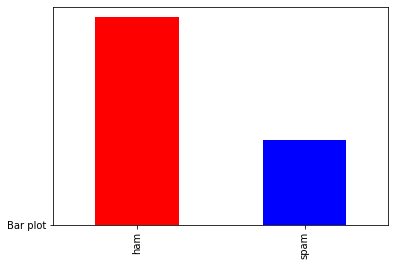

In [22]:
count = pd.value_counts(dataset["label"],sort=True)
count.plot(kind="bar",color=["red","blue"])
plt.plot('Bar plot')
plt.show()

In [23]:
f = feature_extraction.text.CountVectorizer(stop_words ='english')
X = f.fit_transform(dataset["message"])
np.shape(X)

(5171, 50140)

In [24]:
dataset["label"]= dataset["label"].map({"spam":1,"ham":0})
X_train,X_test, y_train, y_test = model_selection.train_test_split(X, dataset['label'], test_size=0.70, random_state=42)

In [25]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [26]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.992263,0.973481,0.963071,0.944709
1,0.11001,0.992263,0.972652,0.967930,0.937853
2,0.22001,0.991618,0.973204,0.967930,0.939623
3,0.33001,0.990974,0.973481,0.966958,0.941343
4,0.44001,0.989684,0.973204,0.965015,0.942125
5,0.55001,0.989684,0.973481,0.962099,0.945559
6,0.66001,0.989039,0.973481,0.959184,0.948127
7,0.77001,0.989039,0.973481,0.956268,0.950725
8,0.88001,0.988395,0.974033,0.953353,0.955209
9,0.99001,0.988395,0.972376,0.947522,0.954946


In [27]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index,:]

alpha             15.070010
Train Accuracy     0.925210
Test Accuracy      0.900000
Test Recall        0.655977
Test Precision     0.988287
Name: 137, dtype: float64

In [28]:
#Random Forest Method
rf = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rf_model = rf.fit(X_train,y_train)

In [29]:
y_pred = rf_model.predict(X_test)
precision,recall,fscore,support =score(y_test,y_pred,pos_label=1, average ='binary')
print('Precision : {} / Recall : {} / fscore : {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))

Precision : 0.89 / Recall : 0.973 / fscore : 0.929 / Accuracy: 0.958


In [30]:
#Using NLP using and TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [31]:
vocab_size = 400
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 16
encode = ({'ham': 0, 'spam': 1} )
#new dataset with replaced values
dataset = dataset.replace(encode)

In [32]:
X = dataset['message']
Y = dataset['label']
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [33]:
X = np.array(X)
y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [34]:
X = pad_sequences(X, maxlen=max_length)

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           6400      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________


In [36]:
num_epochs = 50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.20, random_state=7)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test,y_test), verbose=2)

Epoch 1/50
130/130 - 2s - loss: 0.6262 - accuracy: 0.7065 - val_loss: 0.5732 - val_accuracy: 0.7130 - 2s/epoch - 17ms/step
Epoch 2/50
130/130 - 0s - loss: 0.5260 - accuracy: 0.7304 - val_loss: 0.4387 - val_accuracy: 0.7768 - 402ms/epoch - 3ms/step
Epoch 3/50
130/130 - 0s - loss: 0.3709 - accuracy: 0.8303 - val_loss: 0.2978 - val_accuracy: 0.8676 - 375ms/epoch - 3ms/step
Epoch 4/50
130/130 - 0s - loss: 0.2629 - accuracy: 0.9016 - val_loss: 0.2264 - val_accuracy: 0.9382 - 473ms/epoch - 4ms/step
Epoch 5/50
130/130 - 0s - loss: 0.2050 - accuracy: 0.9342 - val_loss: 0.1896 - val_accuracy: 0.9469 - 411ms/epoch - 3ms/step
Epoch 6/50
130/130 - 0s - loss: 0.1697 - accuracy: 0.9480 - val_loss: 0.1667 - val_accuracy: 0.9440 - 361ms/epoch - 3ms/step
Epoch 7/50
130/130 - 0s - loss: 0.1470 - accuracy: 0.9560 - val_loss: 0.1540 - val_accuracy: 0.9517 - 411ms/epoch - 3ms/step
Epoch 8/50
130/130 - 0s - loss: 0.1311 - accuracy: 0.9596 - val_loss: 0.1426 - val_accuracy: 0.9565 - 387ms/epoch - 3ms/step
Ep

In [37]:
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]


print(f"[+] Accuracy: {accuracy*100:.2f}%")

33/33 [==============================] - 0s 4ms/step - loss: 0.1415 - accuracy: 0.9604
[+] Accuracy: 96.04%


In [38]:
from tensorflow.keras.preprocessing import sequence

In [40]:
#Defining the function
def get_predictions(txts):
    txts = tokenizer.texts_to_sequences(txts)
    txts = sequence.pad_sequences(txts, maxlen=max_length)
    preds = model.predict(txts)
    if(preds[0] > 0.5):
        print("SPAM MESSAGE")
        
    else:
        print('NOT SPAM')

txts=["Sub: ALERT! You have won a free ticket to las vegas. Contact now"]
print(get_predictions(txts))
txts=["Hello Varun, you have been selected for an interview with our company please click the link below to register! CONFIDENTIAL DATA DO NOT SHARE WITH OTHERS"]
print(get_predictions(txts))

SPAM MESSAGE
None
SPAM MESSAGE
None
